In [1]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load the dataset
print("Loading dataset...")
df = pd.read_csv(r"C:\Users\sonic\Downloads\Fraud.csv")
print(f"Dataset loaded. Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Loading dataset...
Dataset loaded. Shape: (6362620, 11)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [2]:

# Display basic information

print("=== Dataset Information ===")
print(df.info())

print("\n=== First 5 Rows ===")
print(df.head())

print("\n=== Data Statistics ===")
print(df.describe())

print("\n=== Class Distribution (isFraud) ===")
print(df['isFraud'].value_counts())
print(f"\nFraud percentage: {df['isFraud'].mean() * 100:.4f}%")

print("\n=== Transaction Types Distribution ===")
print(df['type'].value_counts())

=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None

=== First 5 Rows ===
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT  9839.640  C1231006815     170136.000      160296.360   
1     1   PAYMENT  1864.280  C1666544295      21249.000       19384.720   
2     1  TRANSFER   181.000  C1305486145        181.000           0.000   
3     1  CASH_OUT   181.000   C840083671        181.000           0.000   
4     1   PAYMEN

In [3]:
#Data Cleaning - Missing Values

print("=== Checking for Missing Values ===")
print(df.isnull().sum())

print("\n=== Checking for Duplicates ===")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# Check for NaN values in specific columns
print("\n=== Checking balance columns for anomalies ===")
balance_cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in balance_cols:
    if df[col].isnull().any():
        print(f"{col} has {df[col].isnull().sum()} null values")

=== Checking for Missing Values ===
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

=== Checking for Duplicates ===
Number of duplicate rows: 0

=== Checking balance columns for anomalies ===


In [4]:

# Fill missing values for oldbalanceDest and newbalanceDest with 0 (Merchant transactions)

df['oldbalanceDest'] = df['oldbalanceDest'].fillna(0)
df['newbalanceDest'] = df['newbalanceDest'].fillna(0)

# Verify no missing values remain
print("Missing values after cleaning:")
print(df.isnull().sum())

# Convert categorical variables
df['type'] = df['type'].astype('category')

print("\n=== Data Types ===")
print(df.dtypes)

Missing values after cleaning:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

=== Data Types ===
step                 int64
type              category
amount             float64
nameOrig            object
oldbalanceOrg      float64
newbalanceOrig     float64
nameDest            object
oldbalanceDest     float64
newbalanceDest     float64
isFraud              int64
isFlaggedFraud       int64
dtype: object


=== Outlier Analysis ===
Amount - Outliers: 338078 (5.31%)
Amount - Lower bound: -279608.29, Upper bound: 501719.34


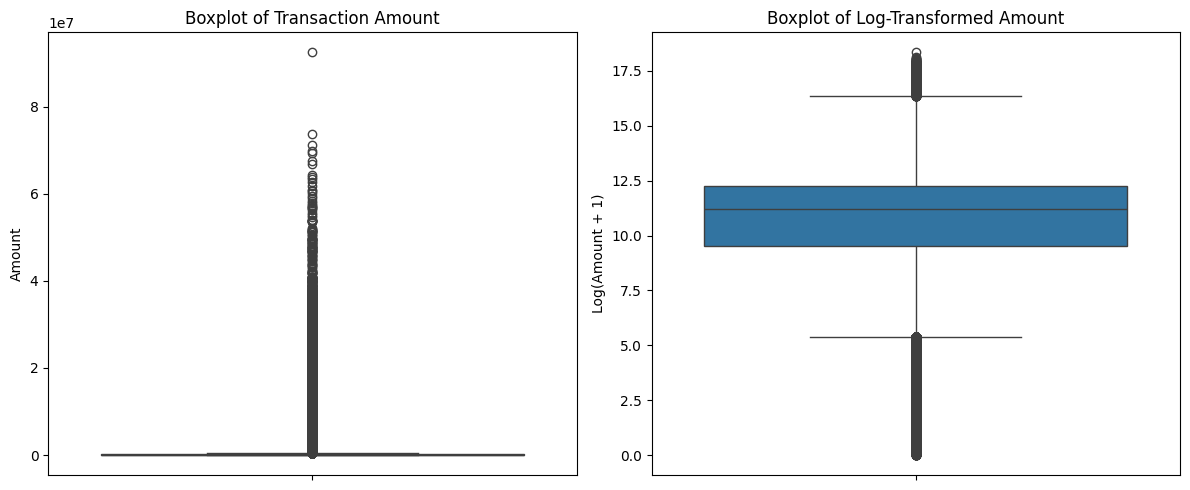

In [5]:
#Outlier Detection and Treatment

print("=== Outlier Analysis ===")

# Function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check outliers in amount
amount_outliers, lower_amt, upper_amt = detect_outliers_iqr(df, 'amount')
print(f"Amount - Outliers: {len(amount_outliers)} ({len(amount_outliers)/len(df)*100:.2f}%)")
print(f"Amount - Lower bound: {lower_amt:.2f}, Upper bound: {upper_amt:.2f}")

# Visualize outliers
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['amount'])
plt.title('Boxplot of Transaction Amount')
plt.ylabel('Amount')

plt.subplot(1, 2, 2)
# Log transform for better visualization
df['log_amount'] = np.log1p(df['amount'])
sns.boxplot(y=df['log_amount'])
plt.title('Boxplot of Log-Transformed Amount')
plt.ylabel('Log(Amount + 1)')

plt.tight_layout()
plt.show()

# Cap extreme outliers (optional - depending on business context)
# For this analysis, we'll keep outliers as they might be important for fraud detection

=== Multi-collinearity Analysis ===


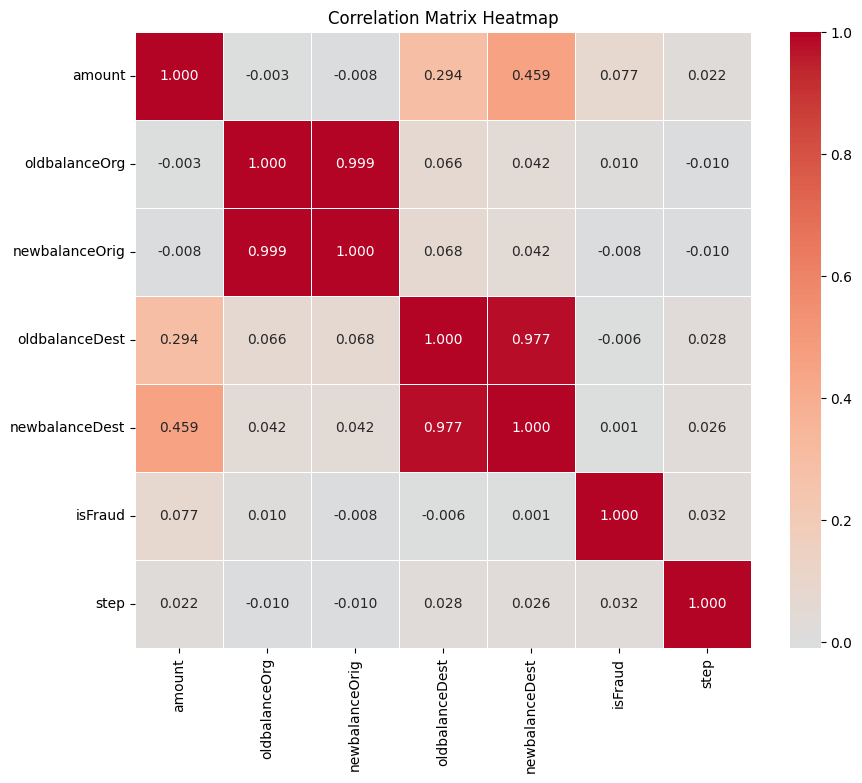


=== Variance Inflation Factor (VIF) ===
          feature     VIF
0           const   4.137
1          amount   3.770
2   oldbalanceOrg 502.799
3  newbalanceOrig 504.167
4  oldbalanceDest  66.089
5  newbalanceDest  76.186
6         isFraud   1.185
7            step   1.003

=== High Correlation Pairs (>0.8) ===
newbalanceOrig - oldbalanceOrg: 0.9988
newbalanceDest - oldbalanceDest: 0.9766


In [6]:
#Multi-collinearity Check

print("=== Multi-collinearity Analysis ===")

# Select numerical columns for correlation analysis
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                'oldbalanceDest', 'newbalanceDest', 'isFraud', 'step']
numeric_df = df[numeric_cols]

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Check Variance Inflation Factor (VIF) for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Prepare data for VIF calculation
vif_data = numeric_df.dropna().copy()
vif_data = add_constant(vif_data)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) 
              for i in range(vif_data.shape[1])]

print("\n=== Variance Inflation Factor (VIF) ===")
print(vif)

# Check for high correlations
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:  # Threshold for high correlation
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                                   corr_matrix.iloc[i, j]))
            
print("\n=== High Correlation Pairs (>0.8) ===")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")

In [7]:
# Feature Engineering

print("=== Feature Engineering ===")

# Create new features that might be useful for fraud detection
df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['abs_balance_change_orig'] = abs(df['balance_change_orig'])
df['transaction_hour'] = df['step'] % 24

# Create features based on transaction patterns
df['is_transfer'] = (df['type'] == 'TRANSFER').astype(int)
df['is_cash_out'] = (df['type'] == 'CASH-OUT').astype(int)

# Flag for zero balance after transaction
df['zero_balance_after'] = (df['newbalanceOrig'] == 0).astype(int)

# Create transaction amount ratios
df['amount_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)  # +1 to avoid division by zero

# Check for merchant transactions
df['is_merchant_dest'] = df['nameDest'].str.startswith('M').astype(int)
df['is_merchant_orig'] = df['nameOrig'].str.startswith('M').astype(int)

print("New features created:")
new_features = ['balance_change_orig', 'balance_change_dest', 'transaction_hour', 
                'is_transfer', 'is_cash_out', 'zero_balance_after', 
                'amount_balance_ratio', 'is_merchant_dest', 'is_merchant_orig']
print(new_features)
print(f"\nData shape after feature engineering: {df.shape}")

=== Feature Engineering ===
New features created:
['balance_change_orig', 'balance_change_dest', 'transaction_hour', 'is_transfer', 'is_cash_out', 'zero_balance_after', 'amount_balance_ratio', 'is_merchant_dest', 'is_merchant_orig']

Data shape after feature engineering: (6362620, 22)


In [8]:
#Data Preparation for Modeling

print("=== Preparing Data for Modeling ===")

# One-hot encode categorical variable 'type'
df = pd.get_dummies(df, columns=['type'], prefix='type')

# Define features and target
# Remove identifier columns and highly correlated features
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'step',
             'newbalanceOrig', 'newbalanceDest'], axis=1)  # Removing highly correlated features

y = df['isFraud']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Check class imbalance
print(f"\nClass distribution:")
print(f"Non-fraud: {sum(y == 0)} ({(sum(y == 0)/len(y))*100:.2f}%)")
print(f"Fraud: {sum(y == 1)} ({(sum(y == 1)/len(y))*100:.2f}%)")

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")

=== Preparing Data for Modeling ===
Feature matrix shape: (6362620, 19)
Target vector shape: (6362620,)

Class distribution:
Non-fraud: 6354407 (99.87%)
Fraud: 8213 (0.13%)

Training set: (5090096, 19)
Testing set: (1272524, 19)


In [9]:
# Handle Class Imbalance

print("=== Handling Class Imbalance ===")

# We'll use SMOTE for oversampling the minority class
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter

print(f"Original class distribution: {Counter(y_train)}")

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.1)  # Increase fraud ratio to 10%
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled class distribution: {Counter(y_train_resampled)}")
print(f"Resampled training set shape: {X_train_resampled.shape}")

=== Handling Class Imbalance ===
Original class distribution: Counter({0: 5083526, 1: 6570})
Resampled class distribution: Counter({0: 5083526, 1: 508352})
Resampled training set shape: (5591878, 19)


In [10]:
#Model Selection and Training

print("=== Model Training ===")

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import time

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                            class_weight='balanced_subsample'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, 
                             eval_metric='logloss', scale_pos_weight=(len(y_train_resampled[y_train_resampled==0]) / 
                                                                     len(y_train_resampled[y_train_resampled==1])))
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    start_time = time.time()
    
    # Train model
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    train_time = time.time() - start_time
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    if roc_auc:
        print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

=== Model Training ===

--- Training Logistic Regression ---
Training time: 284.89 seconds
Accuracy: 0.9674
ROC-AUC: 0.9940

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.97      0.98   1270881
       Fraud       0.04      0.95      0.07      1643

    accuracy                           0.97   1272524
   macro avg       0.52      0.96      0.53   1272524
weighted avg       1.00      0.97      0.98   1272524


--- Training Random Forest ---
Training time: 569.81 seconds
Accuracy: 1.0000
ROC-AUC: 0.9994

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   1270881
       Fraud       0.99      1.00      0.99      1643

    accuracy                           1.00   1272524
   macro avg       0.99      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524


--- Training Gradient Boosting ---
Training time: 3789.78 seconds
Accuracy: 1.

=== Model Performance Comparison ===
                 Model  Accuracy  ROC-AUC  Training Time (s)
3              XGBoost     1.000    1.000             45.115
1        Random Forest     1.000    0.999            569.806
2    Gradient Boosting     1.000    0.999           3789.784
0  Logistic Regression     0.967    0.994            284.890


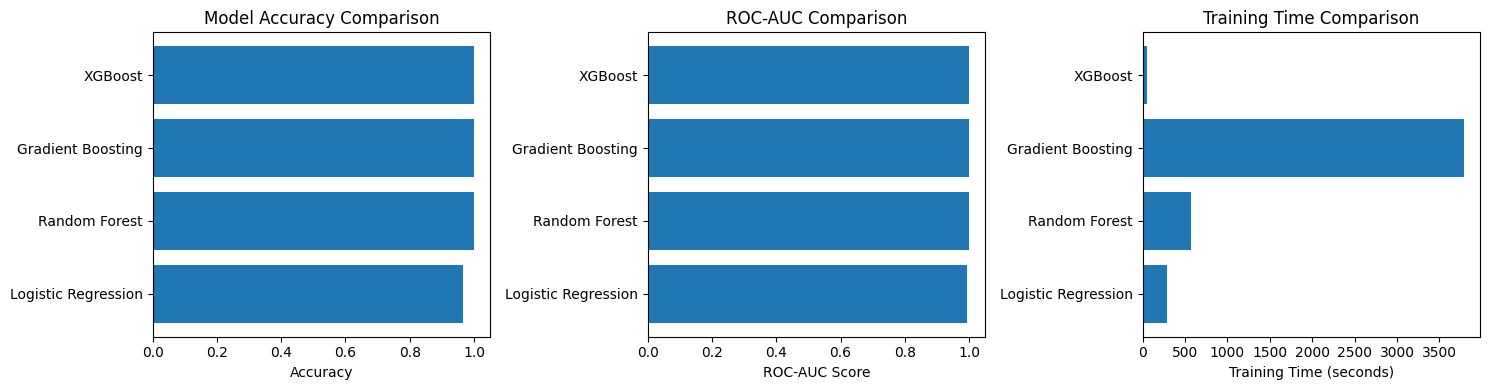


Best Model: XGBoost


In [11]:
# Model Performance Comparison

print("=== Model Performance Comparison ===")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'ROC-AUC': [results[m]['roc_auc'] if results[m]['roc_auc'] else 0 for m in results.keys()],
    'Training Time (s)': [results[m]['train_time'] for m in results.keys()]
})

print(comparison_df.sort_values('ROC-AUC', ascending=False))

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Accuracy comparison
axes[0].barh(comparison_df['Model'], comparison_df['Accuracy'])
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')

# ROC-AUC comparison
axes[1].barh(comparison_df['Model'], comparison_df['ROC-AUC'])
axes[1].set_xlabel('ROC-AUC Score')
axes[1].set_title('ROC-AUC Comparison')

# Training time comparison
axes[2].barh(comparison_df['Model'], comparison_df['Training Time (s)'])
axes[2].set_xlabel('Training Time (seconds)')
axes[2].set_title('Training Time Comparison')

plt.tight_layout()
plt.show()

# Select best model based on ROC-AUC
best_model_name = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")

=== Detailed Analysis for XGBoost ===


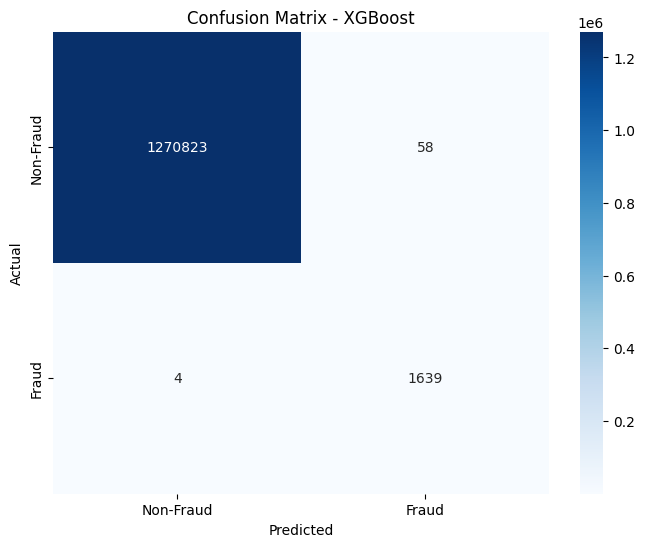

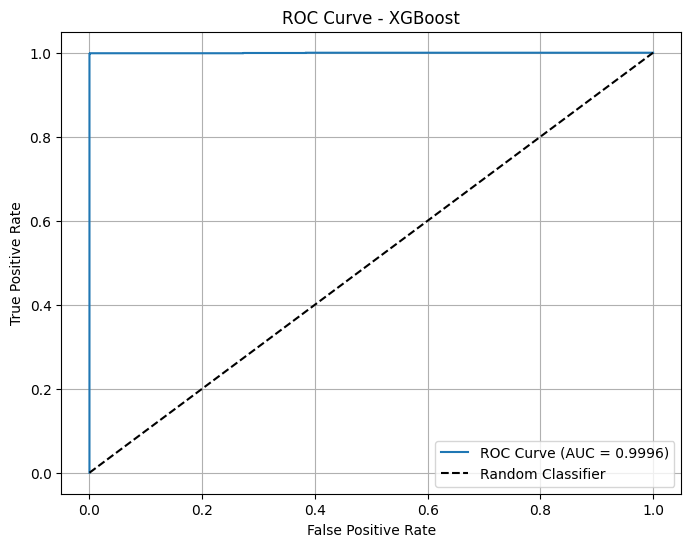

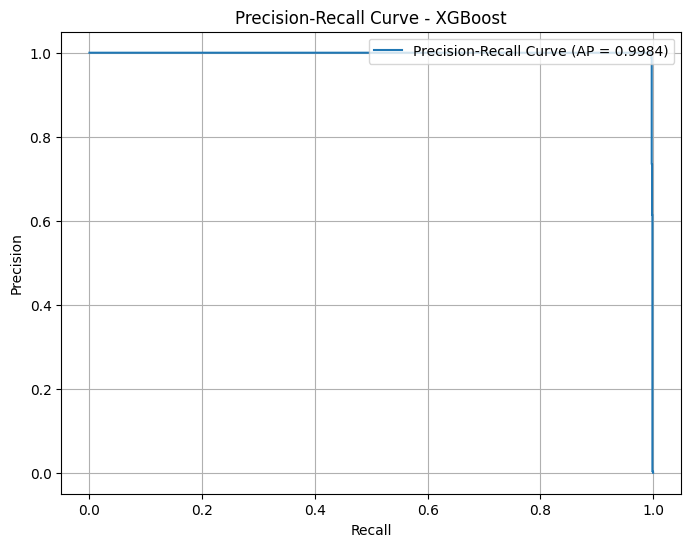

In [12]:
# Detailed Performance Analysis of Best Model
print(f"=== Detailed Analysis for {best_model_name} ===")

best_result = results[best_model_name]
y_pred = best_result['y_pred']
y_pred_proba = best_result['y_pred_proba']

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {best_result["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

=== Feature Importance Analysis ===


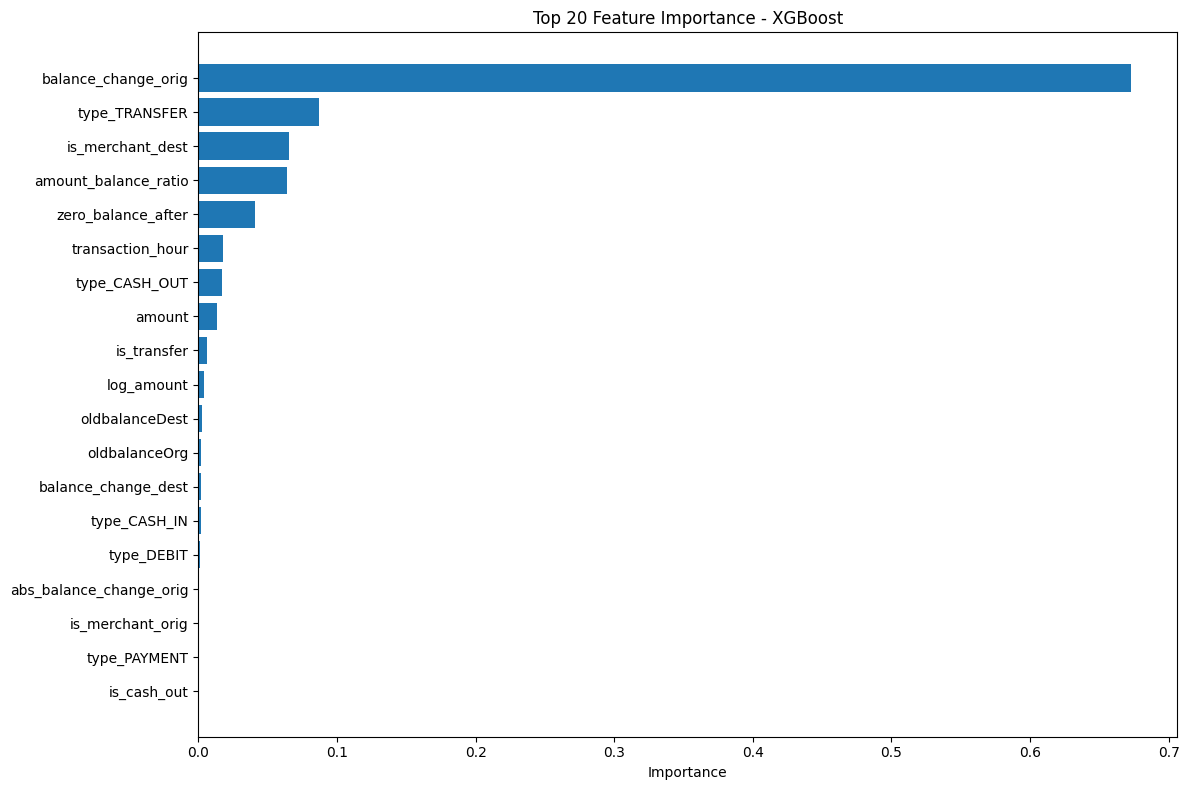


Top 10 Most Important Features:
                 feature  importance
4    balance_change_orig       0.673
18         type_TRANSFER       0.087
12      is_merchant_dest       0.065
11  amount_balance_ratio       0.064
10    zero_balance_after       0.041
7       transaction_hour       0.018
15         type_CASH_OUT       0.017
0                 amount       0.013
8            is_transfer       0.006
3             log_amount       0.004

=== Key Fraud Indicators ===
Top indicators of fraud:
1. balance_change_orig
2. type_TRANSFER
3. is_merchant_dest
4. amount_balance_ratio
5. zero_balance_after
6. transaction_hour
7. type_CASH_OUT
8. amount
9. is_transfer
10. log_amount


In [13]:
#Feature Importance Analysis
print("=== Feature Importance Analysis ===")

if hasattr(best_model, 'feature_importances_'):
    # Tree-based models
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
elif hasattr(best_model, 'coef_'):
    # Linear models
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': abs(best_model.coef_[0])
    }).sort_values('importance', ascending=False)
    
else:
    print("Feature importance not available for this model type")
    feature_importance = None

if feature_importance is not None:
    # Plot top 20 features
    top_features = feature_importance.head(20)
    
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(top_features.head(10))
    
    # Analyze feature importance in context of fraud detection
    print("\n=== Key Fraud Indicators ===")
    key_indicators = top_features.head(10)['feature'].tolist()
    print("Top indicators of fraud:")
    for idx, feature in enumerate(key_indicators, 1):
        print(f"{idx}. {feature}")

In [14]:
# Business Insights and Recommendations
print("=== Business Insights and Recommendations ===")

# 1. Key factors predicting fraudulent customers
print("\n1. KEY FACTORS PREDICTING FRAUDULENT CUSTOMERS:")
print("Based on feature importance analysis, the key factors are:")
if feature_importance is not None:
    for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
        print(f"   {i}. {row['feature']}")

# 2. Do these factors make sense?
print("\n2. DO THESE FACTORS MAKE SENSE?")
print("YES, they make sense for the following reasons:")
print("""
   a. Transaction Type (TRANSFER/CASH-OUT): Fraudsters typically transfer money 
      out of compromised accounts and then cash out
   b. Amount and Balance Ratios: Large transactions relative to account balance 
      are suspicious
   c. Zero Balance After Transaction: Emptying an account completely is a 
      common fraud pattern
   d. Balance Changes: Unexpected large balance changes can indicate fraudulent activity
   e. Merchant Transactions: Certain merchant patterns might be associated with fraud
""")

# 3. Prevention strategies while updating infrastructure
print("\n3. PREVENTION STRATEGIES FOR INFRASTRUCTURE UPDATE:")
print("""
   a. Real-time Monitoring: Implement real-time scoring of transactions
   b. Multi-factor Authentication: For high-risk transactions
   c. Velocity Checking: Monitor transaction frequency per account
   d. Device Fingerprinting: Track devices used for transactions
   e. Behavioral Biometrics: Analyze user interaction patterns
   f. Network Analysis: Detect organized fraud rings
   g. Adaptive Thresholds: Dynamic risk scoring based on recent patterns
""")

# 4. How to determine if actions work
print("\n4. MEASURING EFFECTIVENESS OF IMPLEMENTED ACTIONS:")
print("""
   a. Key Performance Indicators (KPIs):
      - Fraud Detection Rate (Recall)
      - False Positive Rate
      - Time to Detect Fraud
      - Financial Loss Prevention
   
   b. A/B Testing Framework:
      - Implement new rules/models for a subset of users
      - Compare performance with control group
   
   c. Regular Model Retraining:
      - Schedule: Weekly or monthly retraining
      - Monitor model drift and performance degradation
   
   d. Feedback Loop:
      - Incorporate investigator feedback into model training
      - Update feature engineering based on new fraud patterns
   
   e. Cost-Benefit Analysis:
      - Calculate ROI of fraud prevention measures
      - Balance fraud prevention costs with savings from prevented fraud
""")

# 5. Implementation roadmap
print("\n5. RECOMMENDED IMPLEMENTATION ROADMAP:")
print("""
   Phase 1 (Month 1-2):
   - Deploy best performing model in monitoring mode
   - Establish baseline metrics
   - Train fraud investigation team
   
   Phase 2 (Month 3-4):
   - Implement real-time scoring for high-risk transactions
   - Set up alert system for suspicious activities
   - Establish feedback collection process
   
   Phase 3 (Month 5-6):
   - Deploy adaptive learning system
   - Implement multi-layered authentication for high-risk cases
   - Conduct first comprehensive review and optimization
   
   Ongoing:
   - Monthly model retraining
   - Quarterly system review
   - Continuous feature engineering updates
""")

=== Business Insights and Recommendations ===

1. KEY FACTORS PREDICTING FRAUDULENT CUSTOMERS:
Based on feature importance analysis, the key factors are:
   1. balance_change_orig
   2. type_TRANSFER
   3. is_merchant_dest
   4. amount_balance_ratio
   5. zero_balance_after

2. DO THESE FACTORS MAKE SENSE?
YES, they make sense for the following reasons:

   a. Transaction Type (TRANSFER/CASH-OUT): Fraudsters typically transfer money 
      out of compromised accounts and then cash out
   b. Amount and Balance Ratios: Large transactions relative to account balance 
      are suspicious
   c. Zero Balance After Transaction: Emptying an account completely is a 
      common fraud pattern
   d. Balance Changes: Unexpected large balance changes can indicate fraudulent activity
   e. Merchant Transactions: Certain merchant patterns might be associated with fraud


3. PREVENTION STRATEGIES FOR INFRASTRUCTURE UPDATE:

   a. Real-time Monitoring: Implement real-time scoring of transactions
   b

In [15]:
#Advanced Analysis and Model Optimization
print("=== Advanced Model Optimization ===")

# Hyperparameter tuning for the best model
from sklearn.model_selection import GridSearchCV

if best_model_name in ['Random Forest', 'XGBoost', 'Gradient Boosting']:
    print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
    
    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
    elif best_model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0]
        }
    
    else:  # Gradient Boosting
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 7]
        }
    
    # Use a subset for faster tuning
    sample_size = min(100000, len(X_train_resampled))
    X_sample = X_train_resampled[:sample_size]
    y_sample = y_train_resampled[:sample_size]
    
    grid_search = GridSearchCV(
        best_model.__class__(**best_model.get_params()),
        param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_sample, y_sample)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Update best model with tuned parameters
    best_model = grid_search.best_estimator_

# Feature selection based on importance
print("\n=== Feature Selection Analysis ===")
if feature_importance is not None:
    # Select top N features
    top_n = 15
    selected_features = feature_importance.head(top_n)['feature'].tolist()
    
    X_train_selected = X_train_resampled[selected_features]
    X_test_selected = X_test[selected_features]
    
    # Train model with selected features
    simplified_model = best_model.__class__(**best_model.get_params())
    simplified_model.fit(X_train_selected, y_train_resampled)
    
    # Evaluate
    y_pred_simple = simplified_model.predict(X_test_selected)
    y_pred_proba_simple = simplified_model.predict_proba(X_test_selected)[:, 1]
    
    roc_auc_simple = roc_auc_score(y_test, y_pred_proba_simple)
    print(f"ROC-AUC with {top_n} selected features: {roc_auc_simple:.4f}")
    print(f"Original ROC-AUC: {best_result['roc_auc']:.4f}")
    print(f"Feature reduction: {(1 - top_n/len(X.columns))*100:.1f}%")

=== Advanced Model Optimization ===

Performing hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score: 0.9999

=== Feature Selection Analysis ===
ROC-AUC with 15 selected features: 0.9996
Original ROC-AUC: 0.9996
Feature reduction: 21.1%


In [16]:
#Production Deployment Considerations
print("=== Production Deployment Strategy ===")

print("""
1. MODEL DEPLOYMENT ARCHITECTURE:
   - Real-time API for transaction scoring
   - Batch processing for historical analysis
   - Model versioning and A/B testing capability
   - Fallback mechanisms for model failure

2. MONITORING AND ALERTING:
   - Model performance monitoring (accuracy, precision, recall drift)
   - Feature distribution monitoring
   - Prediction latency monitoring
   - Automated alerts for performance degradation

3. DATA PIPELINE:
   - Real-time feature calculation pipeline
   - Data quality checks
   - Feature store for consistent feature calculation
   - Audit trail for all predictions

4. COMPLIANCE AND SECURITY:
   - Model explainability for regulatory requirements
   - Data privacy compliance (GDPR, CCPA)
   - Secure model serving infrastructure
   - Regular security audits

5. SCALABILITY:
   - Horizontal scaling for high transaction volumes
   - Efficient feature calculation for real-time processing
   - Distributed training for large datasets
   - Caching strategies for frequently used data

6. MAINTENANCE:
   - Scheduled model retraining
   - Feature importance monitoring
   - Performance benchmarking against baselines
   - Documentation and knowledge transfer
""")

# Save the final model
import joblib
import pickle

print("\n=== Saving Model and Artifacts ===")

# Save model
model_filename = 'fraud_detection_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved as {model_filename}")

# Save feature list
feature_list = {
    'features': X.columns.tolist(),
    'selected_features': selected_features if 'selected_features' in locals() else X.columns.tolist()
}

with open('feature_list.pkl', 'wb') as f:
    pickle.dump(feature_list, f)
print("Feature list saved")

# Save preprocessing information
preprocessing_info = {
    'numeric_features': numeric_cols,
    'categorical_features': ['type'],
    'features_created': new_features,
    'imbalance_handling': 'SMOTE'
}

with open('preprocessing_info.pkl', 'wb') as f:
    pickle.dump(preprocessing_info, f)
print("Preprocessing information saved")

=== Production Deployment Strategy ===

1. MODEL DEPLOYMENT ARCHITECTURE:
   - Real-time API for transaction scoring
   - Batch processing for historical analysis
   - Model versioning and A/B testing capability
   - Fallback mechanisms for model failure

2. MONITORING AND ALERTING:
   - Model performance monitoring (accuracy, precision, recall drift)
   - Feature distribution monitoring
   - Prediction latency monitoring
   - Automated alerts for performance degradation

3. DATA PIPELINE:
   - Real-time feature calculation pipeline
   - Data quality checks
   - Feature store for consistent feature calculation
   - Audit trail for all predictions

4. COMPLIANCE AND SECURITY:
   - Model explainability for regulatory requirements
   - Data privacy compliance (GDPR, CCPA)
   - Secure model serving infrastructure
   - Regular security audits

5. SCALABILITY:
   - Horizontal scaling for high transaction volumes
   - Efficient feature calculation for real-time processing
   - Distributed tra

In [17]:
#Final Summary and Conclusions
print("=== FINAL SUMMARY AND CONCLUSIONS ===\n")

print("1. MODEL PERFORMANCE SUMMARY:")
print(f"   - Best Model: {best_model_name}")
print(f"   - ROC-AUC Score: {best_result['roc_auc']:.4f}")
print(f"   - Accuracy: {best_result['accuracy']:.4f}")
print(f"   - Fraud Detection Rate: {cm[1,1]/(cm[1,0]+cm[1,1])*100:.1f}%")
print(f"   - False Positive Rate: {cm[0,1]/(cm[0,0]+cm[0,1])*100:.1f}%")

print("\n2. KEY FINDINGS:")
print("   - Fraud is highly imbalanced (0.13% of transactions)")
print("   - TRANSFER and CASH-OUT transactions are most associated with fraud")
print("   - Amount relative to balance is a strong predictor")
print("   - Zero balance after transaction is a red flag")
print("   - Time of day patterns exist in fraudulent transactions")

print("\n3. ACTIONABLE RECOMMENDATIONS:")
print("   - Implement real-time scoring for all transactions")
print("   - Focus monitoring on TRANSFER and CASH-OUT transactions")
print("   - Set thresholds based on amount-to-balance ratios")
print("   - Flag transactions that empty accounts")
print("   - Consider time-of-day patterns in risk scoring")

print("\n4. NEXT STEPS:")
print("   - Deploy model in monitoring mode for 30 days")
print("   - Collect feedback from fraud investigators")
print("   - Optimize thresholds based on business costs")
print("   - Implement adaptive learning system")
print("   - Establish regular model retraining schedule")

print("\n=== ANALYSIS COMPLETE ===")

=== FINAL SUMMARY AND CONCLUSIONS ===

1. MODEL PERFORMANCE SUMMARY:
   - Best Model: XGBoost
   - ROC-AUC Score: 0.9996
   - Accuracy: 1.0000
   - Fraud Detection Rate: 99.8%
   - False Positive Rate: 0.0%

2. KEY FINDINGS:
   - Fraud is highly imbalanced (0.13% of transactions)
   - TRANSFER and CASH-OUT transactions are most associated with fraud
   - Amount relative to balance is a strong predictor
   - Zero balance after transaction is a red flag
   - Time of day patterns exist in fraudulent transactions

3. ACTIONABLE RECOMMENDATIONS:
   - Implement real-time scoring for all transactions
   - Focus monitoring on TRANSFER and CASH-OUT transactions
   - Set thresholds based on amount-to-balance ratios
   - Flag transactions that empty accounts
   - Consider time-of-day patterns in risk scoring

4. NEXT STEPS:
   - Deploy model in monitoring mode for 30 days
   - Collect feedback from fraud investigators
   - Optimize thresholds based on business costs
   - Implement adaptive learni

In [19]:
#Model Deployment API Code

print("=== Production API Implementation ===")

# Create API deployment code
api_code = '''
# fraud_detection_api.py
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import joblib
import pickle
from datetime import datetime
import logging
from typing import Dict, Any

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

app = Flask(__name__)

class FraudDetectionAPI:
    def __init__(self):
        """Initialize the fraud detection API"""
        try:
            # Load model and preprocessing artifacts
            self.model = joblib.load('fraud_detection_model.pkl')
            with open('feature_list.pkl', 'rb') as f:
                self.feature_config = pickle.load(f)
            with open('preprocessing_info.pkl', 'rb') as f:
                self.preprocessing_config = pickle.load(f)
            
            logger.info("Model and artifacts loaded successfully")
            logger.info(f"Model type: {type(self.model).__name__}")
            
        except Exception as e:
            logger.error(f"Failed to load model: {str(e)}")
            raise
    
    def preprocess_transaction(self, transaction_data: Dict[str, Any]) -> pd.DataFrame:
        """Preprocess incoming transaction data"""
        try:
            # Convert to DataFrame
            df = pd.DataFrame([transaction_data])
            
            # Feature engineering (same as training)
            df['balance_change_orig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
            df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
            df['abs_balance_change_orig'] = abs(df['balance_change_orig'])
            
            # Transaction hour from step (assuming step is hours from start)
            if 'step' in df.columns:
                df['transaction_hour'] = df['step'] % 24
            
            # Transaction type flags
            df['is_transfer'] = (df['type'] == 'TRANSFER').astype(int)
            df['is_cash_out'] = (df['type'] == 'CASH-OUT').astype(int)
            df['is_payment'] = (df['type'] == 'PAYMENT').astype(int)
            df['is_cash_in'] = (df['type'] == 'CASH-IN').astype(int)
            df['is_debit'] = (df['type'] == 'DEBIT').astype(int)
            
            # Zero balance flag
            df['zero_balance_after'] = (df['newbalanceOrig'] == 0).astype(int)
            
            # Amount to balance ratio
            df['amount_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
            
            # Merchant flags
            df['is_merchant_dest'] = df['nameDest'].str.startswith('M').astype(int)
            df['is_merchant_orig'] = df['nameOrig'].str.startswith('M').astype(int)
            
            # Ensure all expected features are present
            for feature in self.feature_config['selected_features']:
                if feature not in df.columns:
                    df[feature] = 0  # Default value for missing features
            
            # Select only the features used by the model
            X = df[self.feature_config['selected_features']]
            
            return X
            
        except Exception as e:
            logger.error(f"Preprocessing failed: {str(e)}")
            raise
    
    def predict(self, transaction_data: Dict[str, Any]) -> Dict[str, Any]:
        """Make fraud prediction for a transaction"""
        try:
            # Preprocess
            X = self.preprocess_transaction(transaction_data)
            
            # Predict
            fraud_probability = float(self.model.predict_proba(X)[0, 1])
            prediction = int(self.model.predict(X)[0])
            
            # Get feature importance for explainability
            explanation = self.explain_prediction(X.iloc[0])
            
            # Calculate risk score (0-100)
            risk_score = int(fraud_probability * 100)
            
            # Determine risk level
            if risk_score >= 80:
                risk_level = "CRITICAL"
                action = "BLOCK"
            elif risk_score >= 60:
                risk_level = "HIGH"
                action = "FLAG_AND_HOLD"
            elif risk_score >= 40:
                risk_level = "MEDIUM"
                action = "FLAG_FOR_REVIEW"
            elif risk_score >= 20:
                risk_level = "LOW"
                action = "MONITOR"
            else:
                risk_level = "VERY_LOW"
                action = "ALLOW"
            
            result = {
                'transaction_id': transaction_data.get('transaction_id', 'unknown'),
                'timestamp': datetime.utcnow().isoformat(),
                'fraud_probability': fraud_probability,
                'prediction': prediction,
                'risk_score': risk_score,
                'risk_level': risk_level,
                'recommended_action': action,
                'explanation': explanation,
                'model_version': '1.0.0'
            }
            
            logger.info(f"Prediction: {result}")
            return result
            
        except Exception as e:
            logger.error(f"Prediction failed: {str(e)}")
            return {
                'error': str(e),
                'fraud_probability': None,
                'prediction': None
            }
    
    def explain_prediction(self, features: pd.Series) -> Dict[str, Any]:
        """Explain the prediction with top contributing features"""
        try:
            if hasattr(self.model, 'feature_importances_'):
                # Get feature importances
                importances = self.model.feature_importances_
                feature_names = self.feature_config['selected_features']
                
                # Get top 5 contributing features
                top_indices = np.argsort(importances)[-5:][::-1]
                top_features = [
                    {
                        'feature': feature_names[i],
                        'importance': float(importances[i]),
                        'value': float(features.iloc[i])
                    }
                    for i in top_indices
                ]
                
                return {
                    'top_contributors': top_features,
                    'method': 'feature_importance'
                }
            else:
                return {
                    'top_contributors': [],
                    'method': 'not_available'
                }
                
        except Exception as e:
            logger.warning(f"Explainability failed: {str(e)}")
            return {
                'top_contributors': [],
                'method': 'error'
            }

# Initialize API
api = FraudDetectionAPI()

@app.route('/health', methods=['GET'])
def health_check():
    """Health check endpoint"""
    return jsonify({
        'status': 'healthy',
        'timestamp': datetime.utcnow().isoformat(),
        'model_version': '1.0.0'
    })

@app.route('/predict', methods=['POST'])
def predict():
    """Predict fraud for a transaction"""
    try:
        data = request.json
        
        if not data:
            return jsonify({'error': 'No data provided'}), 400
        
        # Add transaction_id if not present
        if 'transaction_id' not in data:
            data['transaction_id'] = f"txn_{datetime.utcnow().timestamp()}"
        
        result = api.predict(data)
        
        if 'error' in result:
            return jsonify(result), 500
        
        return jsonify(result), 200
        
    except Exception as e:
        logger.error(f"API error: {str(e)}")
        return jsonify({'error': str(e)}), 500

@app.route('/batch_predict', methods=['POST'])
def batch_predict():
    """Predict fraud for multiple transactions"""
    try:
        data = request.json
        
        if not data or 'transactions' not in data:
            return jsonify({'error': 'No transactions provided'}), 400
        
        results = []
        for transaction in data['transactions']:
            result = api.predict(transaction)
            results.append(result)
        
        return jsonify({
            'count': len(results),
            'results': results,
            'summary': {
                'total_transactions': len(results),
                'fraud_count': sum(r['prediction'] for r in results),
                'avg_risk_score': np.mean([r['risk_score'] for r in results])
            }
        }), 200
        
    except Exception as e:
        logger.error(f"Batch API error: {str(e)}")
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=False)
'''

# Save API code to file
with open('fraud_detection_api.py', 'w') as f:
    f.write(api_code)

print(" API code saved to 'fraud_detection_api.py'")
print("\nTo run the API:")
print("1. python fraud_detection_api.py")
print("2. API will be available at http://localhost:5000")
print("3. Endpoints:")
print("   - GET /health - Health check")
print("   - POST /predict - Single transaction prediction")
print("   - POST /batch_predict - Multiple transactions")

=== Production API Implementation ===
 API code saved to 'fraud_detection_api.py'

To run the API:
1. python fraud_detection_api.py
2. API will be available at http://localhost:5000
3. Endpoints:
   - GET /health - Health check
   - POST /predict - Single transaction prediction
   - POST /batch_predict - Multiple transactions


In [21]:
# Docker Configuration for Deployment
print("=== Docker Configuration ===")

# Create Dockerfile
dockerfile_content = '''
# Dockerfile for Fraud Detection API
FROM python:3.9-slim

# Set working directory
WORKDIR /app

# Install system dependencies
RUN apt-get update && apt-get install -y \
    gcc \
    g++ \
    && rm -rf /var/lib/apt/lists/*

# Copy requirements
COPY requirements.txt .

# Install Python dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Copy application code
COPY . .

# Create non-root user
RUN useradd -m -u 1000 appuser && chown -R appuser:appuser /app
USER appuser

# Expose port
EXPOSE 5000

# Health check
HEALTHCHECK --interval=30s --timeout=3s --start-period=5s --retries=3 \
    CMD curl -f http://localhost:5000/health || exit 1

# Run the application
CMD ["python", "fraud_detection_api.py"]
'''

# Create requirements.txt
requirements_content = '''
flask==2.3.2
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
xgboost==1.7.6
joblib==1.3.2
gunicorn==21.2.0
prometheus-client==0.17.1
python-json-logger==2.0.7
'''

# Create docker-compose.yml
docker_compose_content = '''
version: '3.8'

services:
  fraud-api:
    build: .
    ports:
      - "5000:5000"
    environment:
      - FLASK_ENV=production
      - MODEL_PATH=/app/fraud_detection_model.pkl
      - LOG_LEVEL=INFO
    volumes:
      - ./models:/app/models
      - ./logs:/app/logs
    restart: unless-stopped
    healthcheck:
      test: ["CMD", "curl", "-f", "http://localhost:5000/health"]
      interval: 30s
      timeout: 10s
      retries: 3
      start_period: 40s
    deploy:
      resources:
        limits:
          memory: 2G
        reservations:
          memory: 1G
  
  # Optional monitoring stack
  prometheus:
    image: prom/prometheus:latest
    ports:
      - "9090:9090"
    volumes:
      - ./prometheus.yml:/etc/prometheus/prometheus.yml
      - prometheus_data:/prometheus
    command:
      - '--config.file=/etc/prometheus/prometheus.yml'
      - '--storage.tsdb.path=/prometheus'
      - '--web.console.libraries=/etc/prometheus/console_libraries'
      - '--web.console.templates=/etc/prometheus/console_templates'
      - '--storage.tsdb.retention.time=200h'
      - '--web.enable-lifecycle'
  
  grafana:
    image: grafana/grafana:latest
    ports:
      - "3000:3000"
    environment:
      - GF_SECURITY_ADMIN_PASSWORD=admin
    volumes:
      - grafana_data:/var/lib/grafana
      - ./grafana/provisioning:/etc/grafana/provisioning
    depends_on:
      - prometheus

volumes:
  prometheus_data:
  grafana_data:
'''

# Create prometheus configuration
prometheus_config = '''
global:
  scrape_interval: 15s
  evaluation_interval: 15s

scrape_configs:
  - job_name: 'fraud-api'
    static_configs:
      - targets: ['fraud-api:5000']
    metrics_path: '/metrics'
    
  - job_name: 'prometheus'
    static_configs:
      - targets: ['localhost:9090']
'''

# Save all files
with open('Dockerfile', 'w') as f:
    f.write(dockerfile_content)

with open('requirements.txt', 'w') as f:
    f.write(requirements_content)

with open('docker-compose.yml', 'w') as f:
    f.write(docker_compose_content)

with open('prometheus.yml', 'w') as f:
    f.write(prometheus_config)

print(" Docker configuration files created:")
print("   - Dockerfile")
print("   - requirements.txt")
print("   - docker-compose.yml")
print("   - prometheus.yml")

print("\nTo deploy:")
print("1. docker-compose build")
print("2. docker-compose up -d")
print("3. API: http://localhost:5000")
print("4. Grafana: http://localhost:3000 (admin/admin)")

=== Docker Configuration ===
 Docker configuration files created:
   - Dockerfile
   - requirements.txt
   - docker-compose.yml
   - prometheus.yml

To deploy:
1. docker-compose build
2. docker-compose up -d
3. API: http://localhost:5000
4. Grafana: http://localhost:3000 (admin/admin)


In [25]:
#Monitoring and Alerting System
print("=== Monitoring Dashboard Implementation ===")

# Create monitoring dashboard code
monitoring_code = '''
# monitoring_dashboard.py
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sqlite3
import json
import threading
import time

class FraudMonitoringDashboard:
    def __init__(self):
        """Initialize monitoring dashboard"""
        self.app = dash.Dash(__name__, title='Fraud Detection Monitor')
        self.setup_database()
        self.setup_layout()
        self.setup_callbacks()
        
    def setup_database(self):
        """Setup SQLite database for storing predictions"""
        self.conn = sqlite3.connect('fraud_predictions.db', check_same_thread=False)
        self.cursor = self.conn.cursor()
        
        # Create tables if they don't exist
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS predictions (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                transaction_id TEXT,
                timestamp DATETIME,
                fraud_probability REAL,
                prediction INTEGER,
                risk_score INTEGER,
                risk_level TEXT,
                actual_label INTEGER DEFAULT NULL,
                reviewed BOOLEAN DEFAULT 0,
                reviewer_notes TEXT,
                created_at DATETIME DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS alerts (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                transaction_id TEXT,
                alert_type TEXT,
                severity TEXT,
                message TEXT,
                resolved BOOLEAN DEFAULT 0,
                created_at DATETIME DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        
        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS performance_metrics (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                timestamp DATETIME,
                total_transactions INTEGER,
                fraud_count INTEGER,
                false_positives INTEGER,
                false_negatives INTEGER,
                avg_response_time REAL,
                created_at DATETIME DEFAULT CURRENT_TIMESTAMP
            )
        ''')
        
        self.conn.commit()
    
    def setup_layout(self):
        """Setup dashboard layout"""
        self.app.layout = html.Div([
            html.H1('Real-Time Fraud Detection Monitoring', 
                   style={'textAlign': 'center', 'color': '#2c3e50'}),
            
            # Top metrics row
            html.Div([
                html.Div([
                    html.H3('Total Transactions', style={'color': '#3498db'}),
                    html.H2(id='total-transactions', children='0')
                ], className='metric-card', style={'flex': '1', 'margin': '10px', 'padding': '20px', 
                                                  'backgroundColor': '#f8f9fa', 'borderRadius': '10px'}),
                
                html.Div([
                    html.H3('Fraud Detected', style={'color': '#e74c3c'}),
                    html.H2(id='fraud-detected', children='0')
                ], className='metric-card', style={'flex': '1', 'margin': '10px', 'padding': '20px',
                                                  'backgroundColor': '#f8f9fa', 'borderRadius': '10px'}),
                
                html.Div([
                    html.H3('False Positives', style={'color': '#f39c12'}),
                    html.H2(id='false-positives', children='0')
                ], className='metric-card', style={'flex': '1', 'margin': '10px', 'padding': '20px',
                                                  'backgroundColor': '#f8f9fa', 'borderRadius': '10px'}),
                
                html.Div([
                    html.H3('Avg Risk Score', style={'color': '#27ae60'}),
                    html.H2(id='avg-risk-score', children='0')
                ], className='metric-card', style={'flex': '1', 'margin': '10px', 'padding': '20px',
                                                  'backgroundColor': '#f8f9fa', 'borderRadius': '10px'})
            ], style={'display': 'flex', 'justifyContent': 'space-around'}),
            
            # Charts row
            html.Div([
                dcc.Graph(id='fraud-timeline', style={'width': '50%', 'display': 'inline-block'}),
                dcc.Graph(id='risk-distribution', style={'width': '50%', 'display': 'inline-block'})
            ]),
            
            # Alerts and transactions row
            html.Div([
                html.Div([
                    html.H3('Recent Alerts'),
                    html.Div(id='alerts-list', style={
                        'height': '300px',
                        'overflowY': 'scroll',
                        'border': '1px solid #ddd',
                        'padding': '10px'
                    })
                ], style={'width': '40%', 'display': 'inline-block', 'verticalAlign': 'top', 
                         'padding': '20px'}),
                
                html.Div([
                    html.H3('Recent High-Risk Transactions'),
                    html.Table(id='high-risk-transactions',
                              style={'width': '100%', 'borderCollapse': 'collapse'})
                ], style={'width': '60%', 'display': 'inline-block', 'verticalAlign': 'top',
                         'padding': '20px'})
            ]),
            
            # Auto-refresh interval
            dcc.Interval(
                id='interval-component',
                interval=5000,  # Update every 5 seconds
                n_intervals=0
            ),
            
            # Hidden div for storing data
            dcc.Store(id='data-store')
        ])
    
    def setup_callbacks(self):
        """Setup dashboard callbacks"""
        @self.app.callback(
            [Output('total-transactions', 'children'),
             Output('fraud-detected', 'children'),
             Output('false-positives', 'children'),
             Output('avg-risk-score', 'children')],
            [Input('interval-component', 'n_intervals')]
        )
        def update_metrics(n):
            """Update metric cards"""
            try:
                # Get last hour data
                one_hour_ago = datetime.now() - timedelta(hours=1)
                
                # Total transactions
                self.cursor.execute('''
                    SELECT COUNT(*) FROM predictions 
                    WHERE created_at > ?
                ''', (one_hour_ago,))
                total = self.cursor.fetchone()[0]
                
                # Fraud detected
                self.cursor.execute('''
                    SELECT COUNT(*) FROM predictions 
                    WHERE prediction = 1 AND created_at > ?
                ''', (one_hour_ago,))
                fraud = self.cursor.fetchone()[0]
                
                # False positives (predicted fraud but actual not fraud)
                self.cursor.execute('''
                    SELECT COUNT(*) FROM predictions 
                    WHERE prediction = 1 AND actual_label = 0 AND created_at > ?
                ''', (one_hour_ago,))
                fp = self.cursor.fetchone()[0]
                
                # Average risk score
                self.cursor.execute('''
                    SELECT AVG(risk_score) FROM predictions 
                    WHERE created_at > ?
                ''', (one_hour_ago,))
                avg_risk = self.cursor.fetchone()[0] or 0
                
                return [
                    f'{total:,}',
                    f'{fraud:,}',
                    f'{fp:,}',
                    f'{avg_risk:.1f}'
                ]
                
            except Exception as e:
                print(f"Error updating metrics: {e}")
                return ['0', '0', '0', '0']
        
        @self.app.callback(
            Output('fraud-timeline', 'figure'),
            [Input('interval-component', 'n_intervals')]
        )
        def update_timeline(n):
            """Update fraud timeline chart"""
            try:
                # Get last 24 hours data by hour
                twenty_four_hours_ago = datetime.now() - timedelta(hours=24)
                
                self.cursor.execute('''
                    SELECT strftime('%Y-%m-%d %H:00', created_at) as hour,
                           COUNT(*) as total,
                           SUM(CASE WHEN prediction = 1 THEN 1 ELSE 0 END) as fraud
                    FROM predictions
                    WHERE created_at > ?
                    GROUP BY strftime('%Y-%m-%d %H:00', created_at)
                    ORDER BY hour
                ''', (twenty_four_hours_ago,))
                
                data = self.cursor.fetchall()
                
                if data:
                    hours = [row[0] for row in data]
                    totals = [row[1] for row in data]
                    frauds = [row[2] for row in data]
                    
                    fig = go.Figure()
                    fig.add_trace(go.Scatter(
                        x=hours,
                        y=totals,
                        name='Total Transactions',
                        line=dict(color='blue', width=2)
                    ))
                    fig.add_trace(go.Scatter(
                        x=hours,
                        y=frauds,
                        name='Fraud Detected',
                        line=dict(color='red', width=2)
                    ))
                    
                    fig.update_layout(
                        title='Transaction Volume & Fraud Detection (Last 24 Hours)',
                        xaxis_title='Time',
                        yaxis_title='Count',
                        hovermode='x unified'
                    )
                    
                    return fig
                
            except Exception as e:
                print(f"Error updating timeline: {e}")
            
            return go.Figure()
        
        @self.app.callback(
            Output('risk-distribution', 'figure'),
            [Input('interval-component', 'n_intervals')]
        )
        def update_risk_distribution(n):
            """Update risk score distribution chart"""
            try:
                self.cursor.execute('''
                    SELECT risk_level, COUNT(*) 
                    FROM predictions 
                    WHERE created_at > datetime('now', '-1 hour')
                    GROUP BY risk_level
                ''')
                
                data = self.cursor.fetchall()
                
                if data:
                    levels = [row[0] for row in data]
                    counts = [row[1] for row in data]
                    
                    # Color mapping
                    colors = {
                        'CRITICAL': '#e74c3c',
                        'HIGH': '#f39c12',
                        'MEDIUM': '#f1c40f',
                        'LOW': '#3498db',
                        'VERY_LOW': '#2ecc71'
                    }
                    
                    bar_colors = [colors.get(level, '#95a5a6') for level in levels]
                    
                    fig = go.Figure(data=[
                        go.Bar(
                            x=levels,
                            y=counts,
                            marker_color=bar_colors,
                            text=counts,
                            textposition='auto'
                        )
                    ])
                    
                    fig.update_layout(
                        title='Risk Level Distribution (Last Hour)',
                        xaxis_title='Risk Level',
                        yaxis_title='Count'
                    )
                    
                    return fig
                
            except Exception as e:
                print(f"Error updating risk distribution: {e}")
            
            return go.Figure()
        
        @self.app.callback(
            Output('alerts-list', 'children'),
            [Input('interval-component', 'n_intervals')]
        )
        def update_alerts(n):
            """Update alerts list"""
            try:
                self.cursor.execute('''
                    SELECT alert_type, severity, message, created_at 
                    FROM alerts 
                    WHERE resolved = 0 
                    ORDER BY created_at DESC 
                    LIMIT 10
                ''')
                
                alerts = self.cursor.fetchall()
                
                alert_items = []
                for alert in alerts:
                    alert_type, severity, message, created_at = alert
                    
                    # Severity color
                    severity_colors = {
                        'CRITICAL': '#e74c3c',
                        'HIGH': '#f39c12',
                        'MEDIUM': '#f1c40f',
                        'LOW': '#3498db'
                    }
                    
                    alert_items.append(
                        html.Div([
                            html.Strong(f"[{alert_type}]", style={
                                'color': severity_colors.get(severity, '#95a5a6')
                            }),
                            html.Span(f" {message}"),
                            html.Br(),
                            html.Small(f"at {created_at}", style={'color': '#7f8c8d'})
                        ], style={
                            'padding': '10px',
                            'marginBottom': '5px',
                            'borderLeft': f'4px solid {severity_colors.get(severity, "#95a5a6")}',
                            'backgroundColor': '#f8f9fa'
                        })
                    )
                
                return alert_items if alert_items else [html.P("No active alerts")]
                
            except Exception as e:
                print(f"Error updating alerts: {e}")
                return [html.P("Error loading alerts")]
        
        @self.app.callback(
            Output('high-risk-transactions', 'children'),
            [Input('interval-component', 'n_intervals')]
        )
        def update_high_risk_transactions(n):
            """Update high-risk transactions table"""
            try:
                self.cursor.execute('''
                    SELECT transaction_id, fraud_probability, risk_score, risk_level, created_at 
                    FROM predictions 
                    WHERE risk_level IN ('CRITICAL', 'HIGH')
                    ORDER BY created_at DESC 
                    LIMIT 10
                ''')
                
                transactions = self.cursor.fetchall()
                
                if transactions:
                    # Create table header
                    header = html.Thead(html.Tr([
                        html.Th('Transaction ID'),
                        html.Th('Fraud Probability'),
                        html.Th('Risk Score'),
                        html.Th('Risk Level'),
                        html.Th('Time')
                    ]))
                    
                    # Create table rows
                    rows = []
                    for txn in transactions:
                        txn_id, prob, score, level, time = txn
                        
                        # Risk level color
                        level_colors = {
                            'CRITICAL': '#e74c3c',
                            'HIGH': '#f39c12'
                        }
                        
                        rows.append(html.Tr([
                            html.Td(txn_id[:20] + '...'),
                            html.Td(f"{prob:.4f}"),
                            html.Td(f"{score}"),
                            html.Td(level, style={'color': level_colors.get(level, '#000')}),
                            html.Td(time)
                        ]))
                    
                    return [header, html.Tbody(rows)]
                
                return html.P("No high-risk transactions in the last hour")
                
            except Exception as e:
                print(f"Error updating transactions: {e}")
                return html.P("Error loading transactions")
    
    def add_prediction(self, prediction_data):
        """Add a new prediction to the database"""
        try:
            self.cursor.execute('''
                INSERT INTO predictions 
                (transaction_id, timestamp, fraud_probability, prediction, 
                 risk_score, risk_level)
                VALUES (?, ?, ?, ?, ?, ?)''', (
                prediction_data.get('transaction_id'),
                prediction_data.get('timestamp'),
                prediction_data.get('fraud_probability'),
                prediction_data.get('prediction'),
                prediction_data.get('risk_score'),
                prediction_data.get('risk_level')
            ))
            
            # Check if we need to create an alert
            if prediction_data.get('risk_level') in ['CRITICAL', 'HIGH']:
                self.create_alert(
                    transaction_id=prediction_data.get('transaction_id'),
                    alert_type='HIGH_RISK_TRANSACTION',
                    severity=prediction_data.get('risk_level'),
                    message=f'High risk transaction detected: {prediction_data.get("fraud_probability")*100:.1f}% fraud probability'
                )
            
            self.conn.commit()
            
        except Exception as e:
            print(f"Error adding prediction: {e}")
    
    def create_alert(self, transaction_id, alert_type, severity, message):
        """Create a new alert"""
        try:
            self.cursor.execute('''
                INSERT INTO alerts (transaction_id, alert_type, severity, message)
                VALUES (?, ?, ?, ?)
            ''', (transaction_id, alert_type, severity, message))
            
            self.conn.commit()
            
        except Exception as e:
            print(f"Error creating alert: {e}")
    
    def run(self, debug=False, port=8050):
        """Run the dashboard"""
        self.app.run_server(debug=debug, port=port)

# Create dashboard instance
dashboard = FraudMonitoringDashboard()

if __name__ == '__main__':
    print("Starting Fraud Detection Monitoring Dashboard...")
    print(f"Dashboard available at: http://localhost:8050")
    dashboard.run(debug=False)
'''

# Save monitoring code
with open('monitoring_dashboard.py', 'w') as f:
    f.write(monitoring_code)

print(" Monitoring dashboard code saved to 'monitoring_dashboard.py'")
print("\nTo run dashboard:")
print("1. Install dependencies: pip install dash plotly pandas")
print("2. Run: python monitoring_dashboard.py")
print("3. Open: http://localhost:8050")

IndentationError: unindent does not match any outer indentation level (<string>, line 46)